## Description
In this Notebook the LLM from fasttext and the fined-tuned modell (see modeltraining.ipynb) is used. The test data is from the ETL Step before but only includes the German descriptions for testing purposes. 
The similarity between the datasets is plotted from the two different models and compared to each other.

#### Result
No relevant insights could be gained because fasttext does not allow the model to be extended and the models had to be combined. The trained model is weighted too heavily (overfitting). Other models/libraries will be tested

The code was created with the assistance of ChatGPT-4.

In [2]:
import fasttext
import pandas as pd
import numpy as np

In [ ]:
# download from https://fasttext.cc/docs/en/crawl-vectors.html
model_fasttext = fasttext.load_model('data/cc.de.300.bin')
model_trained = fasttext.load_model('data/trained_model.bin')

In [ ]:
# load csv-data into pandas dataframe
df_full = pd.read_csv("data/testdata.csv", delimiter=';', quotechar=',')

# only take every 100. line for testing purposes
df = df_full[::100]

In [4]:
# function to calculate vectors of both models and the combination
def get_vectors(text):
    keywords = text.split(", ")
    vectors_fasttext = []
    vectors_trained = []
    
    for word in keywords:
        vec1 = model_fasttext.get_word_vector(word)
        vec2 = model_trained.get_word_vector(word) 

        vectors_fasttext.append(vec1)
        vectors_trained.append(vec2)

    if vectors_fasttext:
        mean_fasttext = np.mean(vectors_fasttext, axis=0)
    else:
        mean_fasttext = np.zeros(300)

    if vectors_trained:
        mean_trained = np.mean(vectors_trained, axis=0)
    else:
        mean_trained = np.zeros(300)

    mean_combined = (mean_fasttext + mean_trained) / 2

    return mean_fasttext, mean_trained, mean_combined


df["vector_fasttext"], df["vector_trained"], df["vector_combined"] = zip(*df["keyword_DE"].apply(get_vectors))

df.head()

C:\Users\haabs\AppData\Local\Temp\ipykernel_49228\1079101179.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["vector_fasttext"], df["vector_trained"], df["vector_combined"] = zip(*df["keyword_DE"].apply(get_vectors))
C:\Users\haabs\AppData\Local\Temp\ipykernel_49228\1079101179.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["vector_fasttext"], df["vector_trained"], df["vector_combined"] = zip(*df["keyword_DE"].apply(get_vectors))
C:\Users\haabs\AppData\Local\Temp\ipykernel_49228\1079101179.p

,xml_filename,keyword_DE,vector_fasttext,vector_trained,vector_combined
0,__.xml,"bodenerosion, bgdi-bundesgeodaten-infrastruktu...","[-0.018698603, 0.010164743, 0.023525473, 0.011...","[-0.18449764, 0.07355173, 0.16201559, 0.417606...","[-0.10159812, 0.041858237, 0.09277053, 0.21434..."
100,abschlusse-an-den-fachhochschulen-ohne-ph-nach...,bildung-und-wissenschaft,"[0.0037763875, 0.014335002, -0.0032669422, 0.0...","[0.08660346, 0.047854748, 0.2559994, 0.3262863...","[0.045189925, 0.031094875, 0.12636623, 0.16676..."
200,aed-standorte.xml,"defibrillator, gesundheit","[-0.0036398666, -0.019537533, 0.007218482, 0.0...","[-0.19110398, 0.02127162, 0.10699704, -0.05195...","[-0.09737192, 0.0008670436, 0.05710776, -0.020..."
300,alterszentrum.xml,"punktdaten, geodaten, quartiere, stzh, vektord...","[0.0067878184, 0.00070141256, 0.020950237, -0....","[0.17909105, -0.03277686, 0.2654734, -0.005084...","[0.09293944, -0.016037723, 0.14321181, -0.0030..."
400,anderung-des-kantonalbankgesetzes-gegenvorschl...,"kantonal, abstimmung","[0.035608754, 0.0030350517, -0.021900559, -0.0...","[0.48821223, -0.24605036, 0.27543843, -0.14376...","[0.2619105, -0.12150765, 0.12676893, -0.084853..."


In [11]:
from sklearn.metrics.pairwise import cosine_similarity

# extract vectors
vectors_fasttext = np.vstack(df["vector_fasttext"].values)
vectors_trained = np.vstack(df["vector_trained"].values)
vectors_combined = np.vstack(df["vector_combined"].values)

# calculate cosinus-similarity
similarity_matrix_fasttext = cosine_similarity(vectors_fasttext)
similarity_matrix_trained = cosine_similarity(vectors_trained)
similarity_matrix_combined = cosine_similarity(vectors_combined)
diff_matrix = similarity_matrix_combined - similarity_matrix_trained


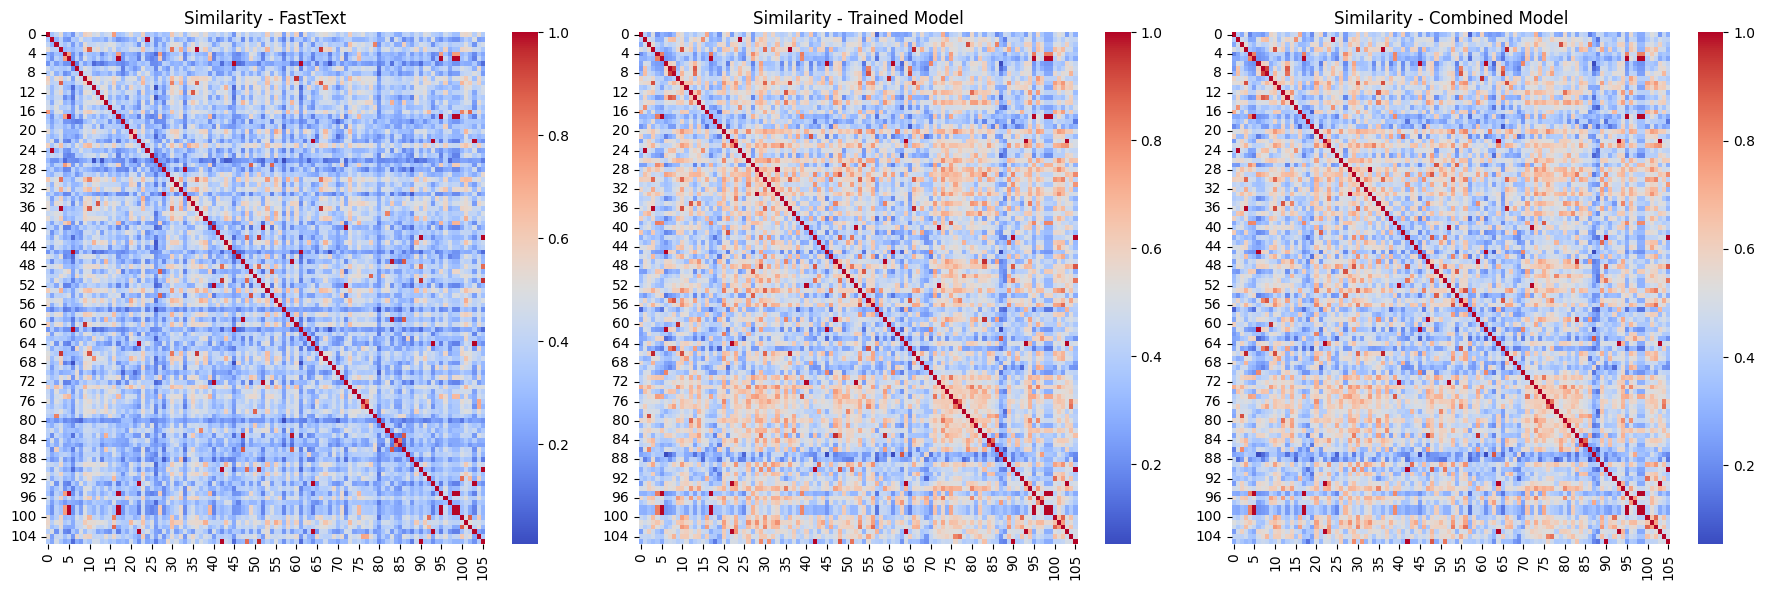

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

titles = ["FastText", "Trained Model", "Combined Model"]
similarity_matrices = [similarity_matrix_fasttext, similarity_matrix_trained, similarity_matrix_combined]

for ax, sim_matrix, title in zip(axes, similarity_matrices, titles):
    sns.heatmap(sim_matrix, ax=ax, annot=False, cmap="coolwarm")
    ax.set_title(f"Similarity - {title}")

plt.tight_layout()
plt.show()

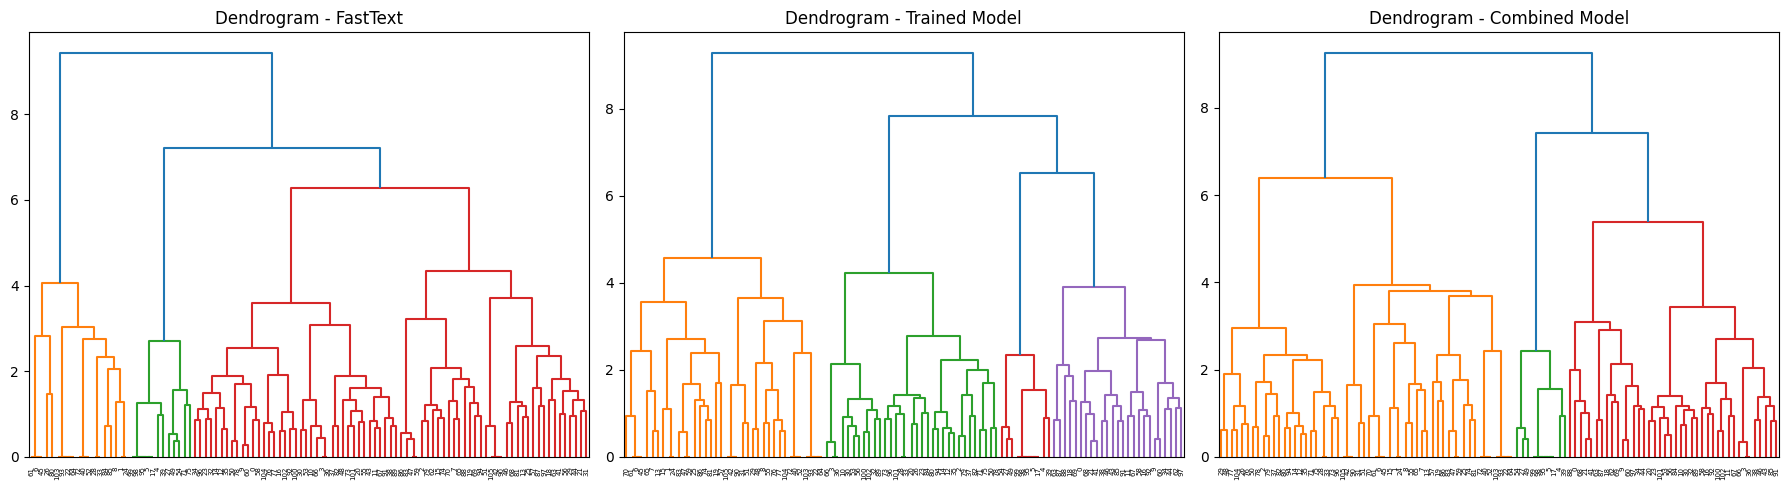

In [19]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

similarity_matrices = [similarity_matrix_fasttext, similarity_matrix_trained, similarity_matrix_combined]
titles = ["FastText", "Trained Model", "Combined Model"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, sim_matrix, title in zip(axes, similarity_matrices, titles):

    linked = linkage(sim_matrix, method='ward')
    
    dendrogram(linked, ax=ax)
    ax.set_title(f"Dendrogram - {title}")
    
plt.tight_layout()
plt.show()


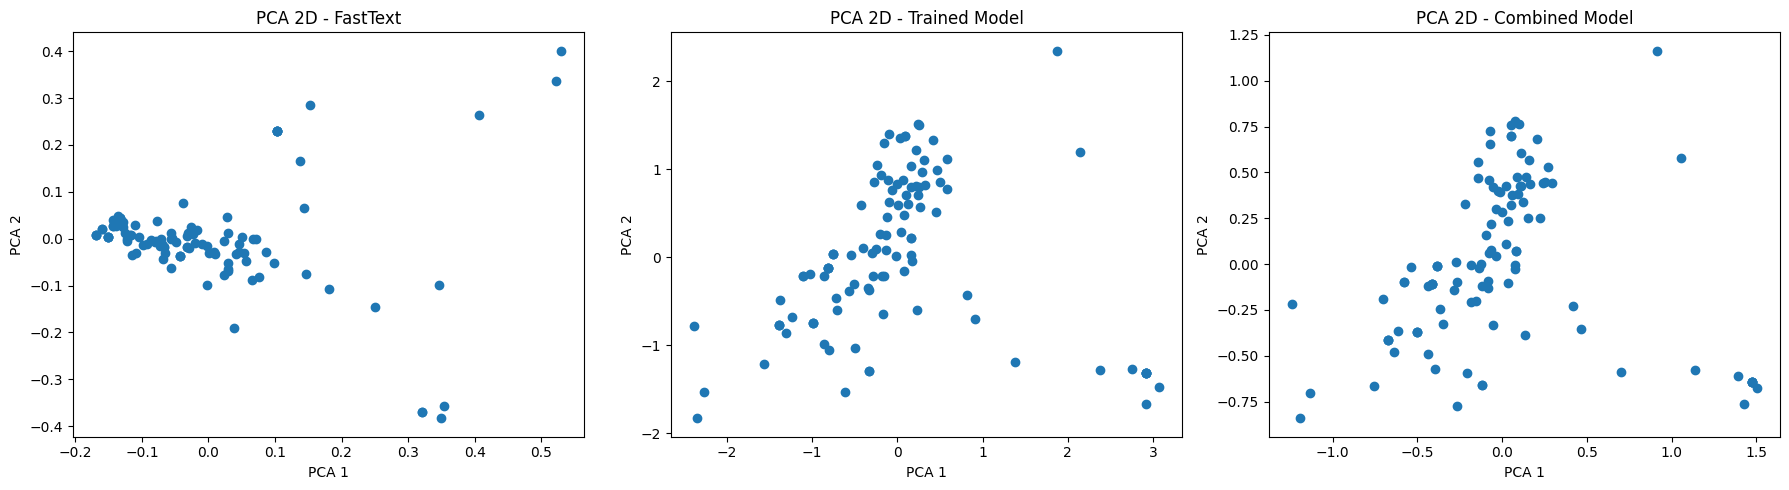

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

vectors = [vectors_fasttext, vectors_trained, vectors_combined]
titles = ["FastText", "Trained Model", "Combined Model"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, sim_matrix, title in zip(axes, vectors, titles):
    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(sim_matrix)

    ax.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1])
    ax.set_title(f"PCA 2D - {title}")
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")

plt.tight_layout()
plt.show()

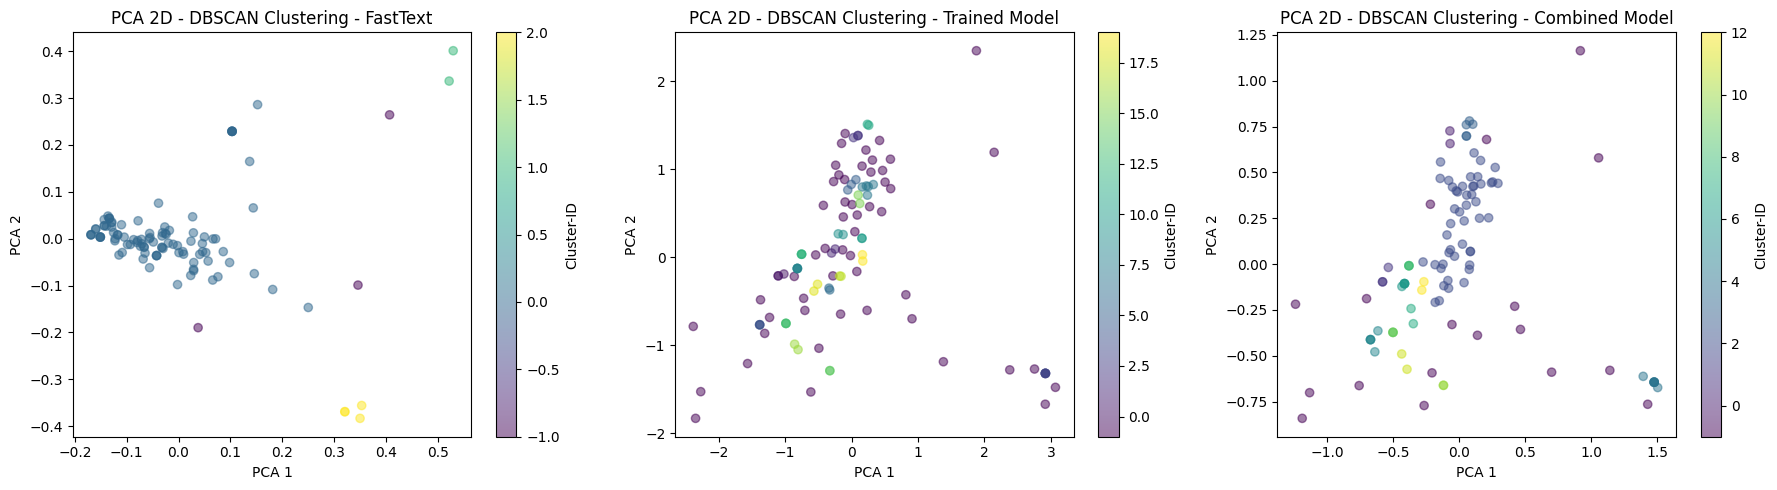

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

vectors = [vectors_fasttext, vectors_trained, vectors_combined]
titles = ["FastText", "Trained Model", "Combined Model"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, sim_matrix, title in zip(axes, vectors, titles):

    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(sim_matrix)

    dbscan = DBSCAN(eps=0.10, min_samples=2, metric='euclidean')
    labels = dbscan.fit_predict(reduced_vectors)

    scatter = ax.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=labels, cmap='viridis', alpha=0.5)

    ax.set_title(f"PCA 2D - DBSCAN Clustering - {title}")
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")

    plt.colorbar(scatter, ax=ax, label="Cluster-ID")

plt.tight_layout()
plt.show()